In [1]:
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import numpy as np
import pandas_ta as ta
import pandas as pd
import warnings

warnings.filterwarnings("ignore")
period = '30'

stock = 'NVDA'
data = yf.download(tickers=stock, period = f'{period}d', interval='2m').round(decimals=3)
data.index = data.index.strftime('%d-%m-%Y-%r')
data.reset_index(inplace=True)
data

[*********************100%***********************]  1 of 1 completed


,Datetime,Open,High,Low,Close,Adj Close,Volume
0,22-03-2023-09:30:00 AM,264.250,264.90,262.620,263.035,263.035,2248229
1,22-03-2023-09:32:00 AM,263.100,263.10,262.370,262.860,262.860,357738
2,22-03-2023-09:34:00 AM,262.804,264.19,262.580,263.830,263.830,506314
3,22-03-2023-09:36:00 AM,263.830,266.28,263.680,266.060,266.060,1142472
4,22-03-2023-09:38:00 AM,266.120,266.69,265.650,266.629,266.629,863380
...,...,...,...,...,...,...,...
5845,03-05-2023-03:52:00 PM,279.420,279.83,279.030,279.140,279.140,232920
5846,03-05-2023-03:54:00 PM,279.070,279.44,278.450,278.980,278.980,418534
5847,03-05-2023-03:56:00 PM,278.940,279.00,278.032,278.032,278.032,324380
5848,03-05-2023-03:58:00 PM,278.050,278.29,277.920,278.010,278.010,481723


In [2]:
def ema(dataset, price, interval):
    ema_column = ta.ema(dataset[price], length=interval)
    data_ema = dataset.assign(ema=ema_column)
    return data_ema

def std(dataset, price):
    std_formula = dataset[price].rolling(window=20).std()
    sma_formula = dataset[price].rolling(window=20).mean()
    std_upper = sma_formula + 2*std_formula
    std_lower = sma_formula - 2*std_formula
    data_std = dataset.assign(upper=std_upper, lower=std_lower, sma=sma_formula)
    return data_std

def atr(dataset, high, low, close, interval):
    average_tr = ta.atr(dataset[high], dataset[low], dataset[close])
    data_atr = dataset.assign(atr = average_tr)
    return data_atr

def ha_close(dataset):
    close_price = (dataset['Open'] + dataset['Close'] + dataset['High'] + dataset['Low']).div(4).values
    data_close = dataset.assign(ha_close=close_price)
    return data_close

def ha_open(dataset):
    open_price = np.array(dataset['Open'])
    close_price = np.array(dataset['Close'])
    counter = 0
    ha_open = []
    for price in range(len(open_price)):
        if counter == 0:
            counter += 1
            ha_open.append('nan')
            continue
        else:
            new_open = 0.5*(open_price[price-1] + close_price[price-1])
            ha_open.append(new_open)
    data_open = dataset.assign(ha_open=ha_open)
    return data_open

def ha_high_low(dataset, open, close):
    df_high = dataset[[open,close,"High"]]
    df_low = dataset[[open,close,"Low"]]
    new_high = df_high.max(axis=1).values
    new_low = df_low.min(axis=1).values
    data_high_low = dataset.assign(ha_high=new_high)
    data_high_low = data_high_low.assign(ha_low=new_low)
    return data_high_low

df_ema_12 = ema(data, 'Close', 12).round(decimals=3)
df_ema_50 = ema(data, 'Close', 50).round(decimals=3)
df_std = std(data, 'Close').round(decimals=3)
df_atr = atr(data, 'High', 'Low', 'Close', 14).round(decimals=3)
df_atr

,Datetime,Open,High,Low,Close,Adj Close,Volume,atr
0,22-03-2023-09:30:00 AM,264.250,264.90,262.620,263.035,263.035,2248229,NaN
1,22-03-2023-09:32:00 AM,263.100,263.10,262.370,262.860,262.860,357738,NaN
2,22-03-2023-09:34:00 AM,262.804,264.19,262.580,263.830,263.830,506314,NaN
3,22-03-2023-09:36:00 AM,263.830,266.28,263.680,266.060,266.060,1142472,NaN
4,22-03-2023-09:38:00 AM,266.120,266.69,265.650,266.629,266.629,863380,NaN
...,...,...,...,...,...,...,...,...
5845,03-05-2023-03:52:00 PM,279.420,279.83,279.030,279.140,279.140,232920,0.883
5846,03-05-2023-03:54:00 PM,279.070,279.44,278.450,278.980,278.980,418534,0.891
5847,03-05-2023-03:56:00 PM,278.940,279.00,278.032,278.032,278.032,324380,0.896
5848,03-05-2023-03:58:00 PM,278.050,278.29,277.920,278.010,278.010,481723,0.859


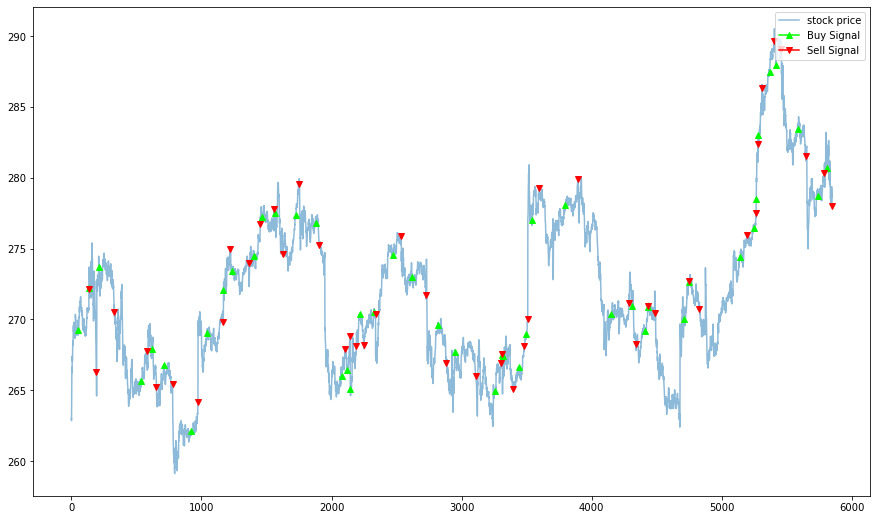

In [11]:
buy_signals = []
sell_signals = []
profit = []
trigger = 0
buy_price = 0
counter = 0

high = data["High"]
open = data["Open"]
close = data["Close"]
low = data["Low"]
atr = df_atr["atr"]
ema_12 = df_ema_12["ema"]
ema_50 = df_ema_50["ema"]
datetime = data["Datetime"]

for price in range(len(data)):
    
    if counter == 0:
        buy_signals.append(float('nan'))
        sell_signals.append(float('nan'))
        counter += 1
        continue
        
    body_candle_1 = close[price-1] - open[price-1]
    body_candle = close[price] - open[price]

    high_stick_hammer = abs(high[price] - close[price])
    low_stick_hammer = abs(open[price] - low[price])

    high_stick_int = abs(high[price] - open[price])
    low_stick_int = abs(close[price] - low[price])

    if price == len(data)-1 and trigger == 1:
        sell_signals.append(close[price])
        buy_signals.append(float('nan'))

    elif price == len(data)-1 and trigger == -1:
        buy_signals.append(float('nan'))
        sell_signals.append(float('nan'))
    
    elif '03:58:00 PM' in datetime[price] and trigger == 1:
        sell_signals.append(close[price])
        buy_signals.append(float('nan'))
        trigger = 0
        
    elif '03:58:00 PM' in datetime[price] and trigger == -1:
        sell_signals.append(float('nan'))
        buy_signals.append(float('nan'))
        trigger = 0
        
    ##### Green Hammer Candlestick patterns    

    elif low_stick_hammer/abs(body_candle) > 3 and body_candle > 0 \
    and high_stick_hammer/low_stick_hammer < 0.25 and ema_12[price] > ema_50[price] and trigger != 1:

        #print("hammer pattern")
        buy_signals.append(close[price])
        sell_signals.append(float('nan'))
        buy_price = close[price]
        trigger = 1

    ###### Red Hammer Candlestick patterns

    elif low_stick_int/abs(body_candle) > 3 and body_candle < 0 \
    and high_stick_int/low_stick_int < 0.25 and ema_12[price] > ema_50[price] and trigger != 1:

        #print("int hammer pattern")
        buy_signals.append(close[price])
        sell_signals.append(float('nan'))
        buy_price = close[price]
        trigger = 1
        
        ##### Bullish/Bearing Engulfing patterns

    elif open[price] <= close[price-1] and close[price] >= open[price-1] \
    and abs(body_candle)/abs(body_candle_1) > 4 and body_candle_1 < 0 and body_candle > 0 \
    and close[price]/open[price] > 1.03 and trigger != 1:

        print(close[price]/open[price])
        print("engulfing pattern")
        buy_signals.append(close[price])
        sell_signals.append(float('nan'))
        profit.append(close[price])
        buy_price = close[price]
        trigger = 1

    ###### ATR Sell off

    elif close[price] > buy_price + 5*atr[price] and trigger != -1\
    or close[price] < buy_price - 5*atr[price] and trigger != -1:

        if trigger == 0:
            buy_signals.append(float('nan'))
            sell_signals.append(float('nan'))
            continue
        else:
            buy_signals.append(float('nan'))
            sell_signals.append(close[price])
            trigger = -1

    else:
        buy_signals.append(float('nan'))
        sell_signals.append(float('nan'))
        
data['Buy Signals'] = buy_signals
data['Sell Signals'] = sell_signals

fig, ax = plt.subplots(figsize=(15,9))

ax.plot(data['Close'], label='stock price', alpha=0.5)
ax.plot(data['Buy Signals'], label='Buy Signal', marker='^', color='#00ff00')
ax.plot(data['Sell Signals'], label='Sell Signal', marker='v', color='#ff0000')
plt.legend(loc='upper right')

In [12]:
profit = data[['Buy Signals','Sell Signals']]
buy = pd.DataFrame(profit['Buy Signals'].dropna())
sell = pd.DataFrame(profit['Sell Signals'].dropna())
buy.reset_index(drop=True, inplace=True)
sell.reset_index(drop=True, inplace=True)
profit_df = buy.join(sell)
bought = buy['Buy Signals']
sold = sell['Sell Signals']
profit_list = []
for priceBought, priceSold in zip(bought, sold):
    diff = (priceSold-priceBought)/priceBought * 100
    profit_list.append(diff)
     
profits = profit_df.join(pd.DataFrame(profit_list))
print(f'Total Profits over {period} days :', sum(profit_list), '%')

Total Profits over 30 days : 5.927734784439433 %


In [13]:
import plotly.graph_objects as go


candlestick = go.Candlestick(
                            x=data.index,
                            open=data['Open'],
                            high=data['High'],
                            low=data['Low'],
                            close=data['Close']
                            )

ema12_graph = go.Scatter(x=data.index, y=df_ema_12['ema'], line=dict(color='orange', width=2))
ema50_graph = go.Scatter(x=data.index, y=df_ema_50['ema'], line=dict(color='orange', width=2))
buy_signal = go.Scatter(x=data.index, y=data['Buy Signals'], mode='markers',  
                        marker = dict(size = 5, color = 'blue', symbol = 'cross'))
sell_signal = go.Scatter(x=data.index, y=data['Sell Signals'], mode='markers',  
                         marker = dict(size = 5, color = 'yellow', symbol = 'cross'))

fig = go.Figure(data=[candlestick, buy_signal, sell_signal])
fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()